# Tensorflow.keras implementation of one-bit-per-weight shifted ReLU CNN for CIFAR 100 
##  https://arxiv.org/abs/1907.06916
## Mark D. McDonnell, Hesham Mostafa, Runchun Wang, Andre van Schaik,
## Single-bit-per-weight deep convolutional neural networks without batch-normalization layers for embedded systems

In [1]:
# select a GPU
import os
os.environ["CUDA_DEVICE_ORDER"] = 'PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"] = '3'

import numpy as np
import h5py
import matplotlib.pyplot as plt
import copy
from scipy.io import savemat,loadmat
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

import tensorflow
print('Tensorflow version = ',tensorflow.__version__)
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler, History

#from tensorflow.keras import backend as K

from ResNetModel import resnet_srelu
from Utils import cutout,LR_WarmRestart,GetDataGen,plot_history

Tensorflow version =  1.13.1


In [2]:
#params
#WhichDataSet = 'CIFAR10'
WhichDataSet = 'CIFAR100'
init_lr = 0.1
epochs = 300
batch_size = 125
My_wd=5e-4/2
resnet_width = 10
resnet_depth = 20
UseBinary=True
UseCutout=True
Loss = 'categorical_crossentropy'
Optimizer = SGD(lr=init_lr,decay=0.0, momentum=0.9, nesterov=False)
Metrics = ['accuracy']
ModelsPath = 'TrainedModels/Tensorflow.keras/'

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
#load and prepare data
if WhichDataSet == 'CIFAR10':
    (x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.cifar10.load_data()
else:
    (x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.cifar100.load_data()
num_classes = np.unique(y_train).shape[0]
K_train = x_train.shape[0]
input_shape = x_train.shape[1:]
x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')#/255.0
y_train = tensorflow.keras.utils.to_categorical(y_train, num_classes)
y_test = tensorflow.keras.utils.to_categorical(y_test, num_classes)


In [4]:
def catcross_entropy_logits_loss():
    def loss(y_true, y_pred):
        return tensorflow.keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=True)
    return loss

In [5]:
#define a datagen or generating training samples with flip and pad/crop augmentation, and if set to True, with cutout augmentation
dataGenerator = GetDataGen(UseCutout)

#define and compile the model
Temperature=25.0
model = resnet_srelu(Temperature,UseBinary,input_shape=input_shape, depth=resnet_depth, num_classes=num_classes,
                     wd=My_wd,width=resnet_width)
model.compile(loss=catcross_entropy_logits_loss() ,optimizer = Optimizer, metrics = Metrics)

#print  the model
model.summary()

#define the learnng rate schedule
steps_per_epoch = int(np.floor(K_train / batch_size))
lr_scheduler = LR_WarmRestart(nbatch=steps_per_epoch,
                              initial_lr=init_lr, min_lr=init_lr*1e-4,
                              epochs_restart = [],
                              Tmult=300.0) 

#define callbacks
history = History()
callbacks = [lr_scheduler,history]

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 32, 32, 3)    12          input_1[0][0]                    
__________________________________________________________________________________________________
binary_conv2d (BinaryConv2D)    (None, 32, 32, 160)  4320        batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 32, 32, 160)  0           binary_conv2d[0][0]              
__________________________________________________________________________________________________
re_lu (ReL

In [6]:
history = model.fit_generator(dataGenerator.flow(x_train, y_train, batch_size=batch_size),
                              validation_data=(x_test, y_test),
                              epochs=epochs,
                              verbose=1,
                              callbacks=callbacks,
                              steps_per_epoch =steps_per_epoch)

Instructions for updating:
Use tf.cast instead.

 Start of Epoch Learning Rate = 0.100000
Epoch 1/300
10000/10000 [==============================] - 8s 786us/sample - loss: 6.6323 - acc: 0.0539

 End of Epoch Learning Rate = 0.099997
400/400 [==============================] - 122s 304ms/step - loss: 7.4148 - acc: 0.0305 - val_loss: 6.6323 - val_acc: 0.0539

 Start of Epoch Learning Rate = 0.099997
Epoch 2/300
10000/10000 [==============================] - 7s 749us/sample - loss: 5.5967 - acc: 0.1182

 End of Epoch Learning Rate = 0.099989
400/400 [==============================] - 117s 292ms/step - loss: 6.1285 - acc: 0.0797 - val_loss: 5.5967 - val_acc: 0.1182

 Start of Epoch Learning Rate = 0.099989
Epoch 3/300
10000/10000 [==============================] - 8s 753us/sample - loss: 4.8241 - acc: 0.1859

 End of Epoch Learning Rate = 0.099975
400/400 [==============================] - 117s 292ms/step - loss: 5.2921 - acc: 0.1383 - val_loss: 4.8241 - val_acc: 0.1859

 Start of Epoch Le

10000/10000 [==============================] - 7s 733us/sample - loss: 3.4361 - acc: 0.6238

 End of Epoch Learning Rate = 0.098158
400/400 [==============================] - 117s 291ms/step - loss: 3.3589 - acc: 0.6207 - val_loss: 3.4361 - val_acc: 0.6238

 Start of Epoch Learning Rate = 0.098158
Epoch 27/300
10000/10000 [==============================] - 7s 743us/sample - loss: 3.4073 - acc: 0.6141

 End of Epoch Learning Rate = 0.098015
400/400 [==============================] - 116s 290ms/step - loss: 3.3616 - acc: 0.6199 - val_loss: 3.4073 - val_acc: 0.6141

 Start of Epoch Learning Rate = 0.098015
Epoch 28/300
10000/10000 [==============================] - 7s 730us/sample - loss: 3.3748 - acc: 0.6289

 End of Epoch Learning Rate = 0.097866
400/400 [==============================] - 116s 291ms/step - loss: 3.3470 - acc: 0.6274 - val_loss: 3.3748 - val_acc: 0.6289

 Start of Epoch Learning Rate = 0.097866
Epoch 29/300
10000/10000 [==============================] - 7s 736us/sample -

10000/10000 [==============================] - 7s 737us/sample - loss: 3.4140 - acc: 0.6484

 End of Epoch Learning Rate = 0.092769
400/400 [==============================] - 116s 291ms/step - loss: 3.2638 - acc: 0.6678 - val_loss: 3.4140 - val_acc: 0.6484

 Start of Epoch Learning Rate = 0.092769
Epoch 53/300
10000/10000 [==============================] - 7s 741us/sample - loss: 3.3670 - acc: 0.6483

 End of Epoch Learning Rate = 0.092495
400/400 [==============================] - 117s 292ms/step - loss: 3.2610 - acc: 0.6701 - val_loss: 3.3670 - val_acc: 0.6483

 Start of Epoch Learning Rate = 0.092495
Epoch 54/300
10000/10000 [==============================] - 7s 730us/sample - loss: 3.4430 - acc: 0.6431

 End of Epoch Learning Rate = 0.092217
400/400 [==============================] - 116s 290ms/step - loss: 3.2385 - acc: 0.6737 - val_loss: 3.4430 - val_acc: 0.6431

 Start of Epoch Learning Rate = 0.092217
Epoch 55/300
10000/10000 [==============================] - 7s 730us/sample -

10000/10000 [==============================] - 7s 742us/sample - loss: 3.2640 - acc: 0.6732

 End of Epoch Learning Rate = 0.084229
400/400 [==============================] - 116s 291ms/step - loss: 3.0829 - acc: 0.6997 - val_loss: 3.2640 - val_acc: 0.6732

 Start of Epoch Learning Rate = 0.084229
Epoch 79/300
10000/10000 [==============================] - 7s 740us/sample - loss: 3.2581 - acc: 0.6634

 End of Epoch Learning Rate = 0.083845
400/400 [==============================] - 116s 290ms/step - loss: 3.0687 - acc: 0.6988 - val_loss: 3.2581 - val_acc: 0.6634

 Start of Epoch Learning Rate = 0.083845
Epoch 80/300
10000/10000 [==============================] - 7s 749us/sample - loss: 3.7810 - acc: 0.6435

 End of Epoch Learning Rate = 0.083458
400/400 [==============================] - 117s 293ms/step - loss: 3.1106 - acc: 0.6969 - val_loss: 3.7810 - val_acc: 0.6435

 Start of Epoch Learning Rate = 0.083458
Epoch 81/300
10000/10000 [==============================] - 7s 735us/sample -

10000/10000 [==============================] - 7s 735us/sample - loss: 3.1747 - acc: 0.6674

 End of Epoch Learning Rate = 0.073167
400/400 [==============================] - 116s 291ms/step - loss: 2.8474 - acc: 0.7285 - val_loss: 3.1747 - val_acc: 0.6674

 Start of Epoch Learning Rate = 0.073167
Epoch 105/300
10000/10000 [==============================] - 7s 736us/sample - loss: 3.1784 - acc: 0.6669

 End of Epoch Learning Rate = 0.072702
400/400 [==============================] - 116s 291ms/step - loss: 2.8567 - acc: 0.7244 - val_loss: 3.1784 - val_acc: 0.6669

 Start of Epoch Learning Rate = 0.072702
Epoch 106/300
10000/10000 [==============================] - 7s 736us/sample - loss: 3.1622 - acc: 0.6717

 End of Epoch Learning Rate = 0.072235
400/400 [==============================] - 116s 290ms/step - loss: 2.8394 - acc: 0.7313 - val_loss: 3.1622 - val_acc: 0.6717

 Start of Epoch Learning Rate = 0.072235
Epoch 107/300
10000/10000 [==============================] - 7s 727us/sampl

10000/10000 [==============================] - 7s 732us/sample - loss: 3.0720 - acc: 0.6884

 End of Epoch Learning Rate = 0.060400
400/400 [==============================] - 116s 291ms/step - loss: 2.6086 - acc: 0.7584 - val_loss: 3.0720 - val_acc: 0.6884

 Start of Epoch Learning Rate = 0.060400
Epoch 131/300
10000/10000 [==============================] - 7s 729us/sample - loss: 3.0159 - acc: 0.6880

 End of Epoch Learning Rate = 0.059887
400/400 [==============================] - 117s 291ms/step - loss: 2.5840 - acc: 0.7618 - val_loss: 3.0159 - val_acc: 0.6880

 Start of Epoch Learning Rate = 0.059887
Epoch 132/300
10000/10000 [==============================] - 7s 735us/sample - loss: 2.9719 - acc: 0.6964

 End of Epoch Learning Rate = 0.059373
400/400 [==============================] - 116s 291ms/step - loss: 2.5557 - acc: 0.7657 - val_loss: 2.9719 - val_acc: 0.6964

 Start of Epoch Learning Rate = 0.059373
Epoch 133/300
10000/10000 [==============================] - 7s 730us/sampl

10000/10000 [==============================] - 7s 733us/sample - loss: 2.8593 - acc: 0.6908

 End of Epoch Learning Rate = 0.046866
400/400 [==============================] - 116s 290ms/step - loss: 2.2200 - acc: 0.7981 - val_loss: 2.8593 - val_acc: 0.6908

 Start of Epoch Learning Rate = 0.046866
Epoch 157/300
10000/10000 [==============================] - 7s 728us/sample - loss: 2.9120 - acc: 0.6845

 End of Epoch Learning Rate = 0.046343
400/400 [==============================] - 116s 291ms/step - loss: 2.1881 - acc: 0.8055 - val_loss: 2.9120 - val_acc: 0.6845

 Start of Epoch Learning Rate = 0.046343
Epoch 158/300
10000/10000 [==============================] - 7s 730us/sample - loss: 2.8033 - acc: 0.7020

 End of Epoch Learning Rate = 0.045822
400/400 [==============================] - 116s 290ms/step - loss: 2.1603 - acc: 0.8093 - val_loss: 2.8033 - val_acc: 0.7020

 Start of Epoch Learning Rate = 0.045822
Epoch 159/300
10000/10000 [==============================] - 7s 729us/sampl

10000/10000 [==============================] - 7s 728us/sample - loss: 2.5944 - acc: 0.7073

 End of Epoch Learning Rate = 0.033563
400/400 [==============================] - 116s 290ms/step - loss: 1.7349 - acc: 0.8541 - val_loss: 2.5944 - val_acc: 0.7073

 Start of Epoch Learning Rate = 0.033563
Epoch 183/300
10000/10000 [==============================] - 7s 725us/sample - loss: 2.6267 - acc: 0.7017

 End of Epoch Learning Rate = 0.033070
400/400 [==============================] - 116s 291ms/step - loss: 1.7187 - acc: 0.8556 - val_loss: 2.6267 - val_acc: 0.7017

 Start of Epoch Learning Rate = 0.033070
Epoch 184/300
10000/10000 [==============================] - 7s 729us/sample - loss: 2.6231 - acc: 0.6985

 End of Epoch Learning Rate = 0.032578
400/400 [==============================] - 116s 291ms/step - loss: 1.7137 - acc: 0.8526 - val_loss: 2.6231 - val_acc: 0.6985

 Start of Epoch Learning Rate = 0.032578
Epoch 185/300
10000/10000 [==============================] - 7s 732us/sampl

10000/10000 [==============================] - 7s 729us/sample - loss: 2.2865 - acc: 0.7215

 End of Epoch Learning Rate = 0.021472
400/400 [==============================] - 117s 292ms/step - loss: 1.2284 - acc: 0.8996 - val_loss: 2.2865 - val_acc: 0.7215

 Start of Epoch Learning Rate = 0.021472
Epoch 209/300
10000/10000 [==============================] - 7s 730us/sample - loss: 2.3469 - acc: 0.7212

 End of Epoch Learning Rate = 0.021044
400/400 [==============================] - 117s 292ms/step - loss: 1.2184 - acc: 0.8995 - val_loss: 2.3469 - val_acc: 0.7212

 Start of Epoch Learning Rate = 0.021044
Epoch 210/300
10000/10000 [==============================] - 7s 744us/sample - loss: 2.0876 - acc: 0.7250

 End of Epoch Learning Rate = 0.020619
400/400 [==============================] - 117s 292ms/step - loss: 1.2009 - acc: 0.8995 - val_loss: 2.0876 - val_acc: 0.7250

 Start of Epoch Learning Rate = 0.020619
Epoch 211/300
10000/10000 [==============================] - 7s 740us/sampl

10000/10000 [==============================] - 7s 746us/sample - loss: 2.1123 - acc: 0.7346

 End of Epoch Learning Rate = 0.011483
400/400 [==============================] - 116s 290ms/step - loss: 0.7621 - acc: 0.9411 - val_loss: 2.1123 - val_acc: 0.7346

 Start of Epoch Learning Rate = 0.011483
Epoch 235/300
10000/10000 [==============================] - 8s 754us/sample - loss: 2.1304 - acc: 0.7371

 End of Epoch Learning Rate = 0.011152
400/400 [==============================] - 116s 291ms/step - loss: 0.7465 - acc: 0.9421 - val_loss: 2.1304 - val_acc: 0.7371

 Start of Epoch Learning Rate = 0.011152
Epoch 236/300
10000/10000 [==============================] - 7s 736us/sample - loss: 2.0054 - acc: 0.7353

 End of Epoch Learning Rate = 0.010824
400/400 [==============================] - 117s 292ms/step - loss: 0.7280 - acc: 0.9453 - val_loss: 2.0054 - val_acc: 0.7353

 Start of Epoch Learning Rate = 0.010824
Epoch 237/300
10000/10000 [==============================] - 7s 743us/sampl

10000/10000 [==============================] - 7s 731us/sample - loss: 1.9071 - acc: 0.7653

 End of Epoch Learning Rate = 0.004332
400/400 [==============================] - 116s 291ms/step - loss: 0.4497 - acc: 0.9745 - val_loss: 1.9071 - val_acc: 0.7653

 Start of Epoch Learning Rate = 0.004332
Epoch 261/300
10000/10000 [==============================] - 7s 740us/sample - loss: 1.8125 - acc: 0.7619

 End of Epoch Learning Rate = 0.004122
400/400 [==============================] - 117s 292ms/step - loss: 0.4442 - acc: 0.9752 - val_loss: 1.8125 - val_acc: 0.7619

 Start of Epoch Learning Rate = 0.004122
Epoch 262/300
10000/10000 [==============================] - 7s 734us/sample - loss: 1.9245 - acc: 0.7694

 End of Epoch Learning Rate = 0.003916
400/400 [==============================] - 117s 292ms/step - loss: 0.4377 - acc: 0.9753 - val_loss: 1.9245 - val_acc: 0.7694

 Start of Epoch Learning Rate = 0.003916
Epoch 263/300
10000/10000 [==============================] - 7s 732us/sampl

10000/10000 [==============================] - 7s 740us/sample - loss: 1.9996 - acc: 0.7796

 End of Epoch Learning Rate = 0.000546
400/400 [==============================] - 116s 291ms/step - loss: 0.3426 - acc: 0.9877 - val_loss: 1.9996 - val_acc: 0.7796

 Start of Epoch Learning Rate = 0.000546
Epoch 287/300
10000/10000 [==============================] - 7s 741us/sample - loss: 1.9661 - acc: 0.7789

 End of Epoch Learning Rate = 0.000473
400/400 [==============================] - 117s 291ms/step - loss: 0.3419 - acc: 0.9882 - val_loss: 1.9661 - val_acc: 0.7789

 Start of Epoch Learning Rate = 0.000473
Epoch 288/300
10000/10000 [==============================] - 7s 743us/sample - loss: 2.0152 - acc: 0.7825

 End of Epoch Learning Rate = 0.000404
400/400 [==============================] - 117s 292ms/step - loss: 0.3382 - acc: 0.9889 - val_loss: 2.0152 - val_acc: 0.7825

 Start of Epoch Learning Rate = 0.000404
Epoch 289/300
10000/10000 [==============================] - 7s 738us/sampl

In [7]:
#get final performance

y_pred = model.predict(x_test)
print('Test accuracy (%):', 100*sum(np.argmax(y_pred,-1)==np.argmax(y_test,-1))/y_test.shape[0])

Test accuracy (%): 78.41


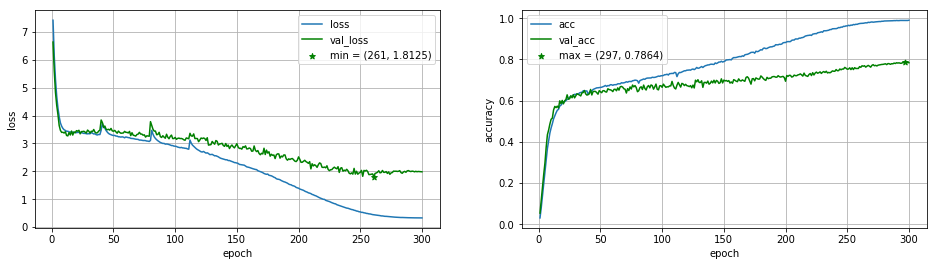

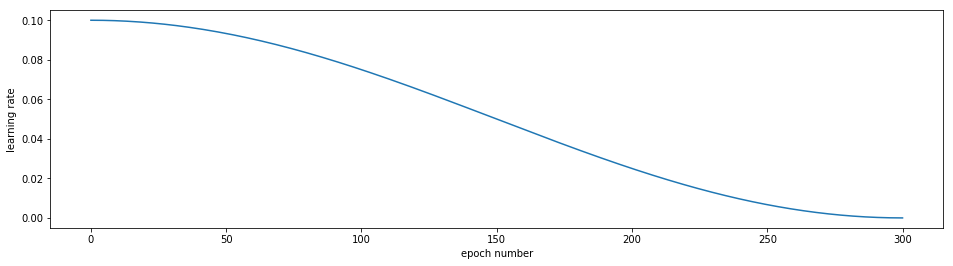

In [8]:
#plot loss and accuracy
plot_history(model.history.history)

#plot learning rate schedule
plt.figure(figsize=(16,4))
plt.plot(np.arange(0,len(lr_scheduler.lr_used))/steps_per_epoch,lr_scheduler.lr_used)
plt.xlabel('epoch number')
plt.ylabel('learning rate')
plt.show()

In [9]:
#save the weigts used for updating
model.save_weights(ModelsPath+'Final_weights_'+WhichDataSet+'_OneBitPerWeight_model_sReLU.h5')